In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pingouin
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
###load data

state_list = []
reward_list = []
crash_list = []

nSub = 47
starting_sub = 302

sub_list = np.arange(nSub)
nSub = len(sub_list)

for iSub in sub_list:
    
    dir_path = 'traj_from_data_v2/sub'+str(iSub+starting_sub)
    observations = np.load(dir_path+'/observations_back.npy')
    
    rewards = np.load(dir_path+'/rewards.npy')
    num_crash = np.load(dir_path+'/num_crash.npy')

    state_list.append(observations)
    reward_list.append(rewards)
    crash_list.append(num_crash)

df = pd.read_csv('behavior_v2/survey_data/data_survey.csv')
gender_str = np.array(df.sex)
gender = np.array([gender_str[x] == 'Male' for x in range(len(gender_str))])+1 #1=female, 2=male
age = np.array(df.age_month)
BIS = np.array(df.bis_total)
BIS_cog = np.array(df.bis_l2_cog_imp)
BIS_motor = np.array(df.bis_l2_motor_imp)
BIS_nonplan = np.array(df.bis_l2_nonplanning_imp)

df_ddt = pd.read_csv('behavior_v2/survey_data/data_ddt.csv')
log_k = np.array(df_ddt.ddt_logk)

df_gng = pd.read_csv('behavior_v2/survey_data/data_gng.csv')
gng_error = np.array(df_gng.error_rate)
gng_rt = np.array(df_gng.go_rt)

mean_reward = [np.mean(reward_list[x]) for x in range(nSub)]

active_over = np.load('data_npy/n_active_over.npy')
passive_over = np.load('data_npy/n_passive_over.npy')
over_list = active_over+passive_over

## speed list
mean_speed = np.zeros(nSub)
for iSub in range(nSub):
    speed_list = state_list[iSub][:,0]
    speed_list = speed_list[speed_list>=0]
    mean_speed[iSub] = np.mean(speed_list)

## distance list
mean_distance = np.zeros(nSub)
for iSub in range(nSub):
    expert_observations = state_list[iSub]
    distance_list = np.array([expert_observations[x][5+np.round(expert_observations[x,1]*2).astype(int)] for x in range(len(expert_observations))])
    mean_distance[iSub] = np.mean(distance_list)

first half mean 1127.7390641840127 second half mean 1236.535012190129


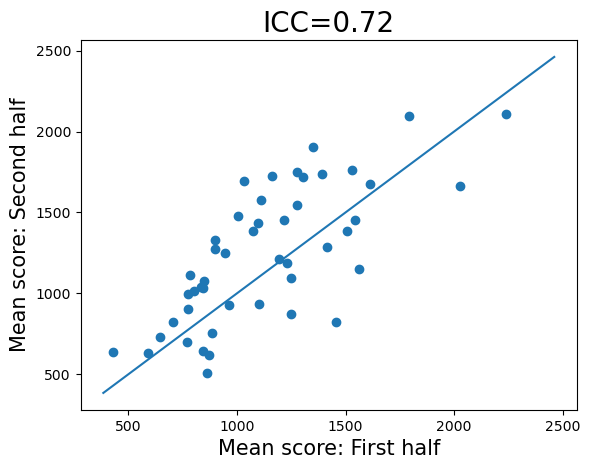

In [3]:
## first-half vs second-half reward
mean_reward_first = [np.mean(reward_list[x][:np.round(len(reward_list[x])/2).astype(int)]) for x in range(nSub)]
mean_reward_second = [np.mean(reward_list[x][np.round(len(reward_list[x])/2).astype(int):]) for x in range(nSub)]

df = pd.DataFrame({'sub':np.concatenate((np.arange(len(mean_reward_first)),np.arange(len(mean_reward_first)))),
                   'score':np.concatenate((mean_reward_first,mean_reward_second)),'rater':np.array([1]*len(mean_reward_first)+[2]*len(mean_reward_first))})

plt.scatter(mean_reward_first,mean_reward_second)

min_reward = min(min(mean_reward_first),min(mean_reward_second))
max_reward = max(max(mean_reward_first),max(mean_reward_second))

ICC = pingouin.intraclass_corr(data = df, targets='sub', raters='rater', ratings='score') 

plt.plot([min_reward*0.9,max_reward*1.1],[min_reward*0.9,max_reward*1.1])
plt.title('ICC='+str(np.around(ICC.ICC[2],2)),fontsize = 20)
plt.ylabel('Mean score: Second half',fontsize = 15)
plt.xlabel('Mean score: First half',fontsize = 15)

print("first half mean", np.mean(mean_reward_first),"second half mean", np.mean(mean_reward_second))

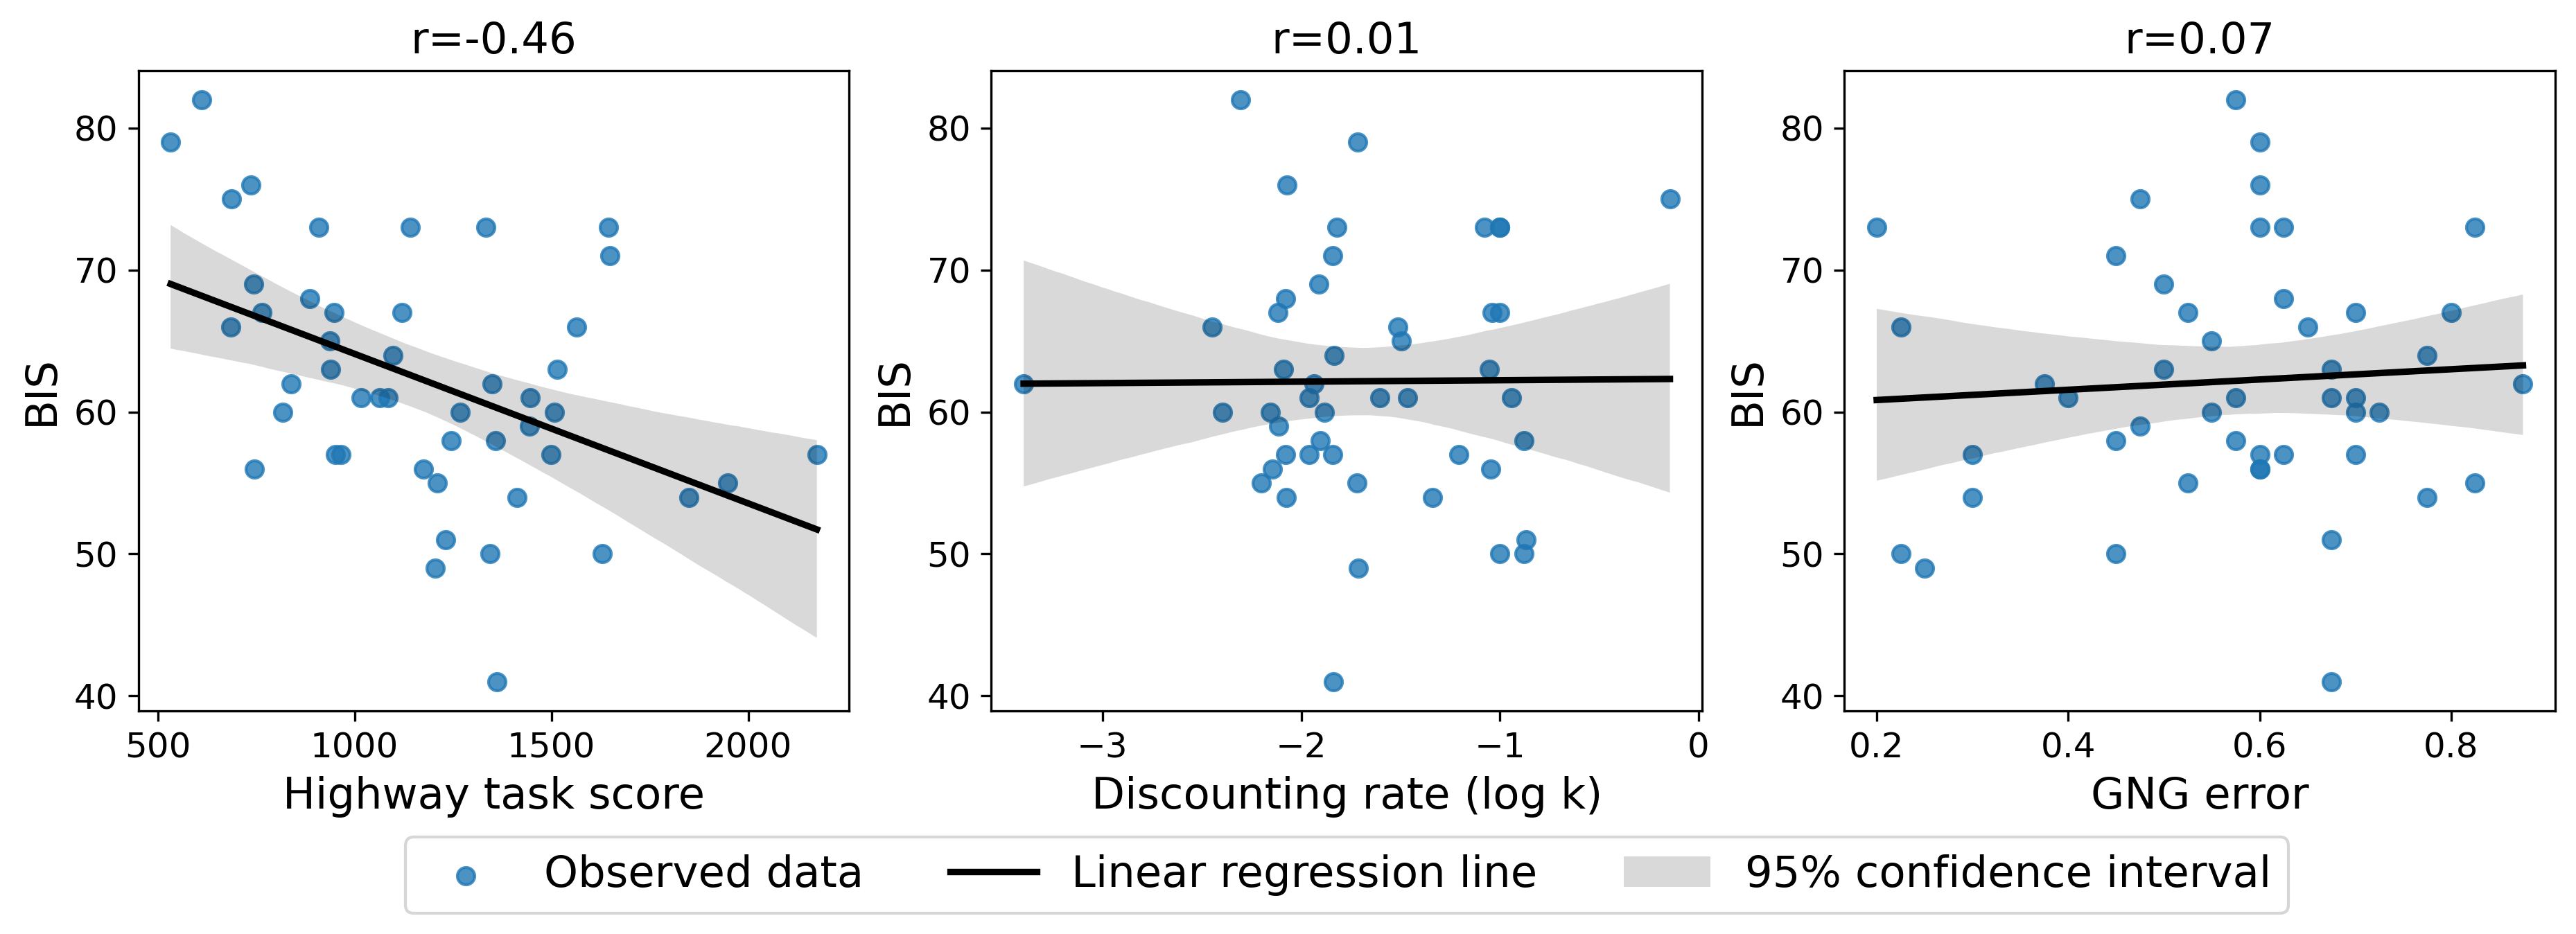

In [4]:
###all three plots
plt.rcParams['figure.dpi'] = 300
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (15,4))
sns.regplot(np.array(mean_reward), BIS, ci=95,ax=ax1,n_boot=10000,line_kws={"color": "k",'label': 'Linear regression line'},label="Observed data")
ax1.set_title('r='+str(np.around(np.corrcoef(np.array(mean_reward),BIS)[0,1],decimals=2)),fontsize = 15)
ax1.set_xlabel('Highway task score',fontsize = 15)
ax1.set_ylabel('BIS',fontsize = 15)
ax1.collections[1].set_label('95% confidence interval')
ax1.tick_params(axis='both', which='major', labelsize=12)

sns.regplot(np.array(log_k), np.array(BIS), ci=95,ax=ax2,n_boot=10000,line_kws={"color": "k",'label': 'Linear regression line'},label="Observed data")
ax2.set_title('r='+str(np.around(np.corrcoef(np.array(log_k),BIS)[0,1],decimals=2)),fontsize = 15)
ax2.set_xlabel('Discounting rate (log k)',fontsize = 15)
ax2.set_ylabel('BIS',fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax2.collections[1].set_label('95% confidence interval')
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35),
          ncol=3, fancybox=True, fontsize = 15)

sns.regplot(np.array(gng_error), np.array(BIS), ci=95,ax=ax3,n_boot=10000,line_kws={"color": "k"})
ax3.set_title('r='+str(np.around(np.corrcoef(np.array(gng_error),BIS)[0,1],decimals=2)),fontsize = 15)
ax3.set_xlabel('GNG error',fontsize = 15)
ax3.set_ylabel('BIS',fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=12)

In [5]:
### full data matrix

data = {
    'DDT log(k)': log_k,
    'GNG error':gng_error,
    'GNG RT':gng_rt,
    'Highway score':mean_reward,
    'Highway speed':mean_speed,
    'Highway distance':mean_distance,
    'Highway overtaking':np.array(over_list),
    'Highway crash':np.array(crash_list),
    'BIS': BIS,
    'BIS cognitive':BIS_cog,
    'BIS motor':BIS_motor,
    'BIS nonplan':BIS_nonplan
}
dataframe = pd.DataFrame(data)

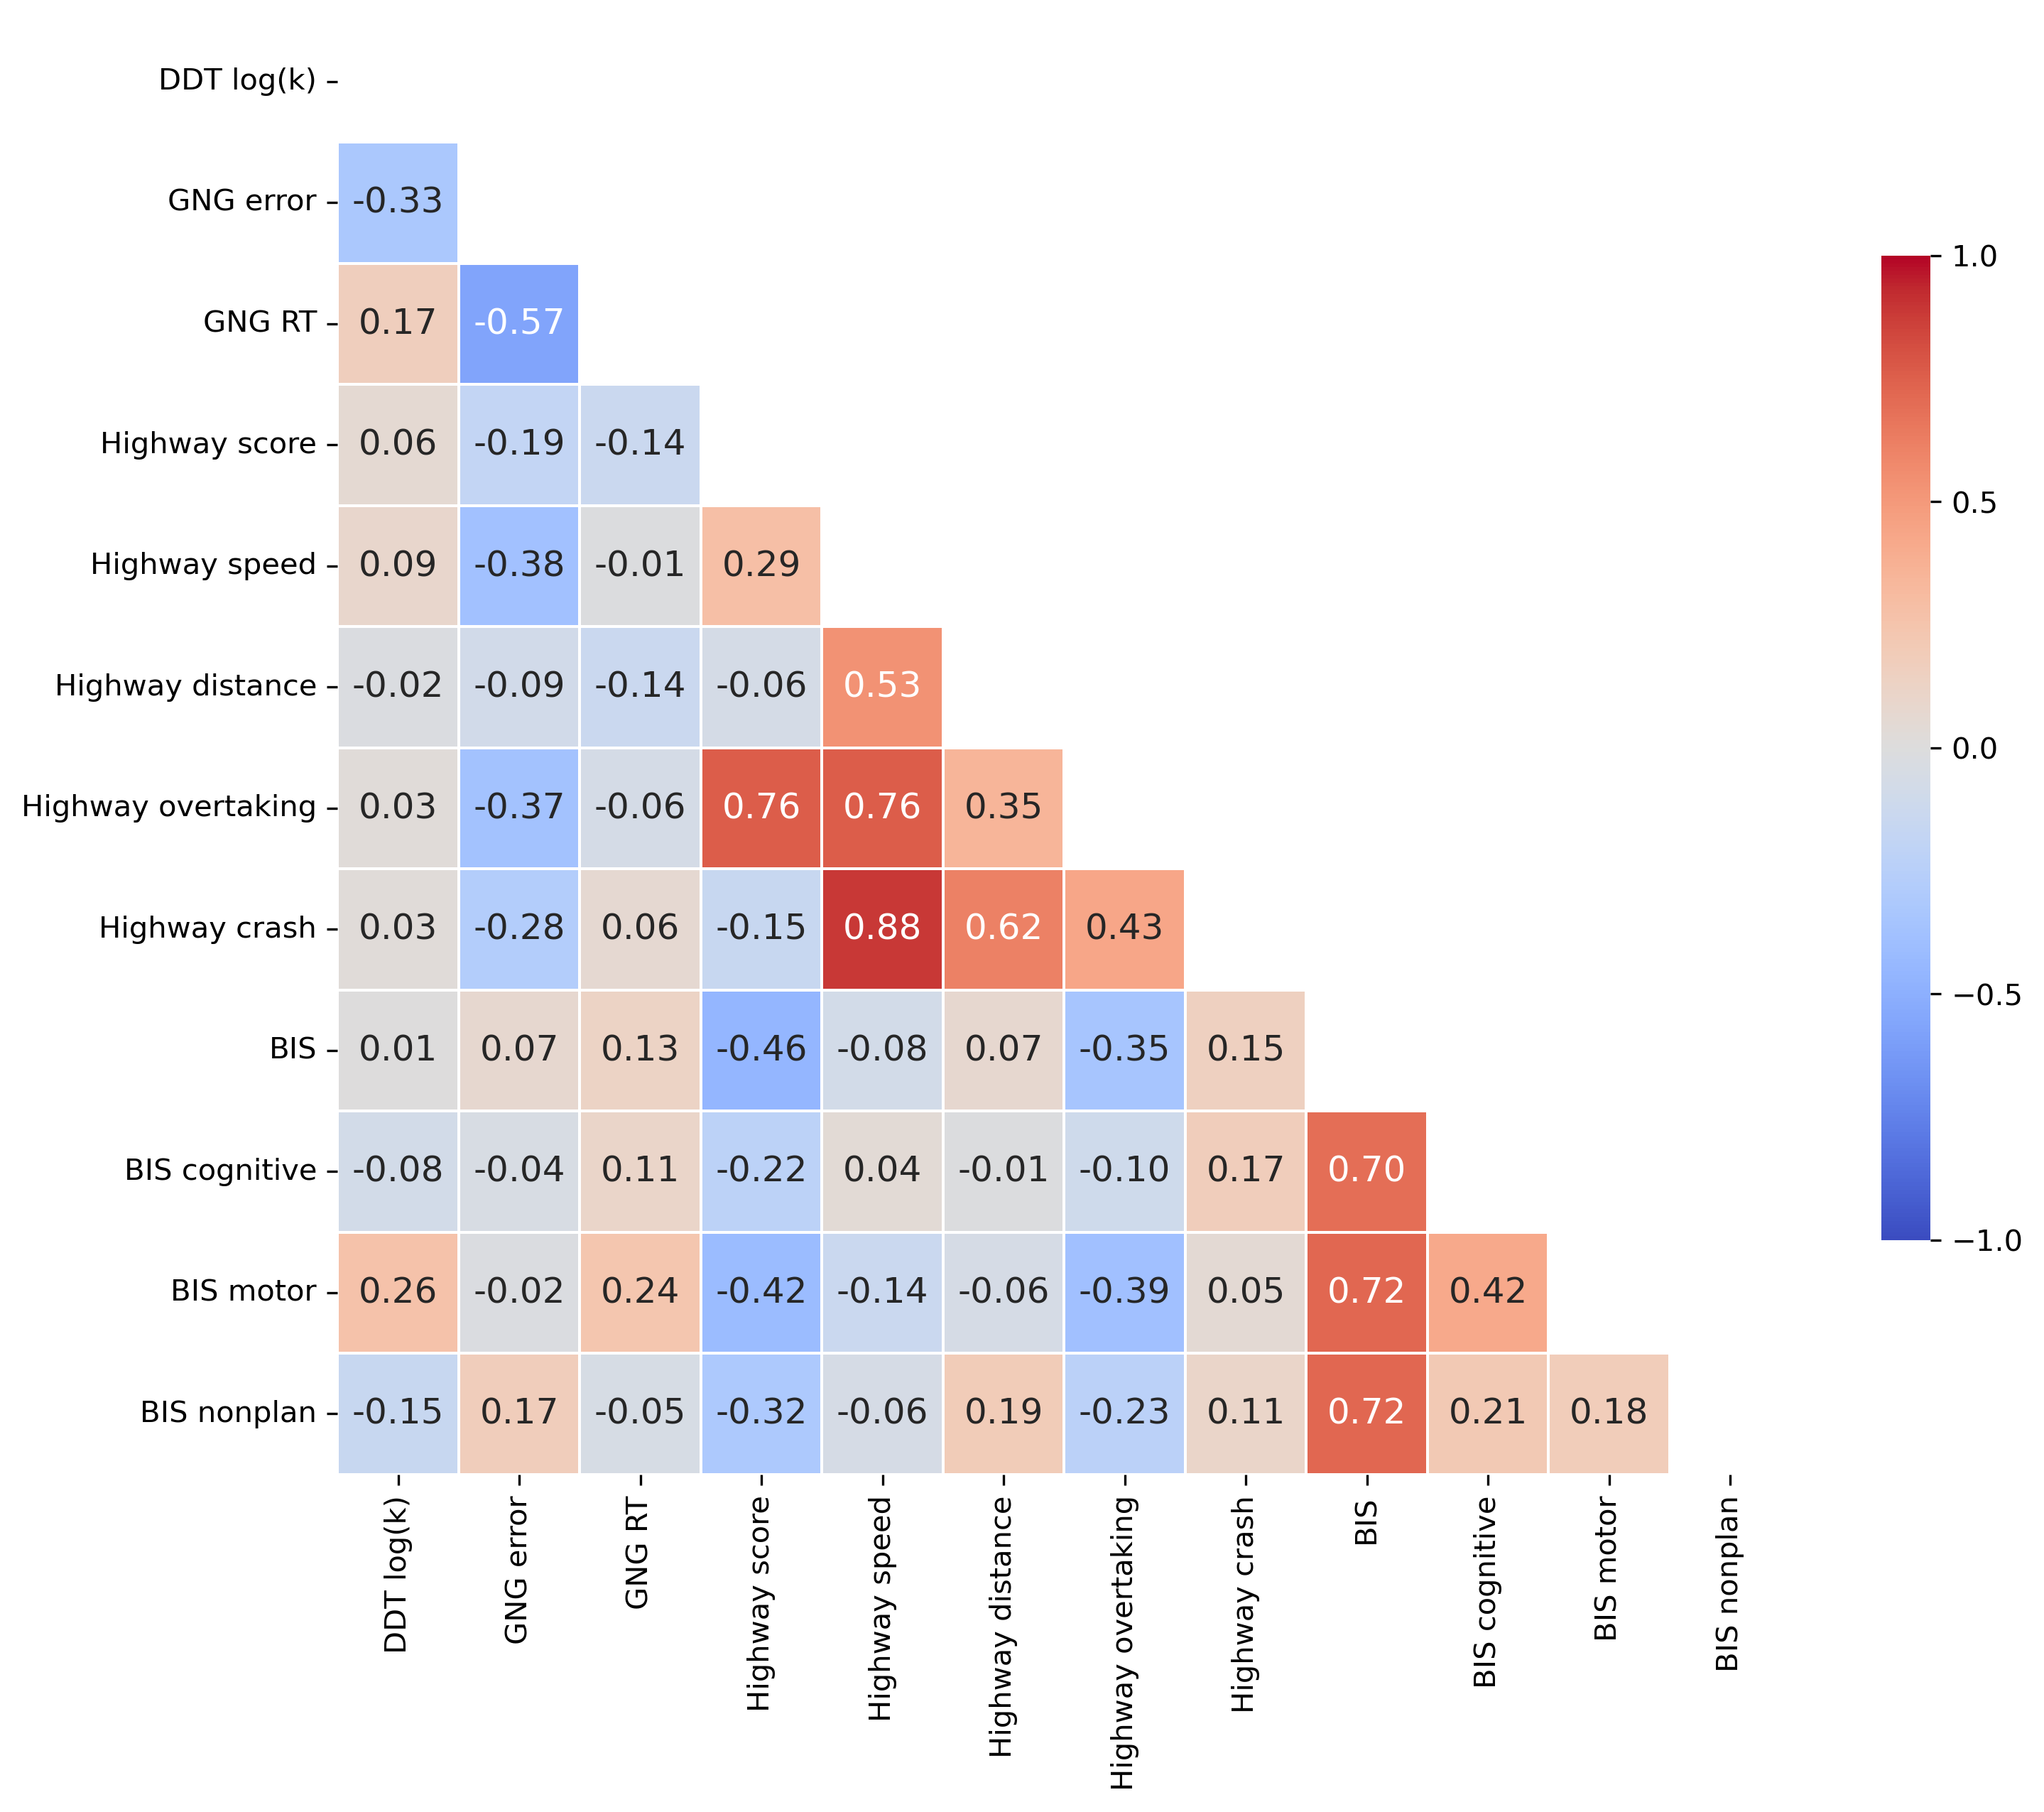

In [6]:
### full correlation matrix

corr_matrix = dataframe.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12},
                      fmt='.2f')